Creating model...

Model Dimensions:
Input: torch.Size([4, 5, 8])
Encoder outputs: torch.Size([4, 5, 16])
Encoder hidden: torch.Size([1, 4, 16])
Context vector: torch.Size([4, 1, 16])
Attention weights: torch.Size([4, 5, 1])

Training model...
Epoch [20/100], Loss: 1.1059
Epoch [40/100], Loss: 1.1214
Epoch [60/100], Loss: 0.9246
Epoch [80/100], Loss: 0.9151
Epoch [100/100], Loss: 1.0049


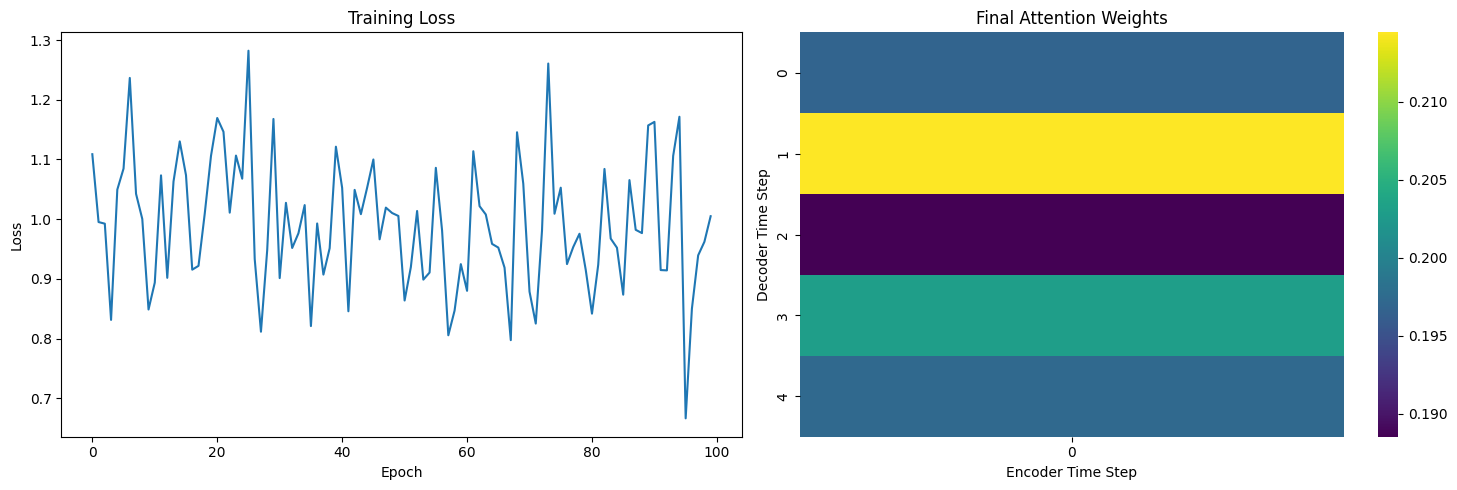


Testing model...
Test Loss: 0.8508


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)  # Set seed for NumPy random number generator
torch.manual_seed(42)  # Set seed for PyTorch random number generator

def generate_sample_data(batch_size=1, seq_length=5, input_dim=8):
    """
    Generate random input sequences and corresponding shifted target sequences.

    Args:
        batch_size (int): Number of sequences in a batch.
        seq_length (int): Length of each sequence.
        input_dim (int): Dimensionality of each input vector.

    Returns:
        x (torch.Tensor): Randomly generated input sequences of shape [batch_size, seq_length, input_dim].
        y (torch.Tensor): Target sequences obtained by circularly shifting x by one step along the sequence dimension.
    """
    x = torch.randn(batch_size, seq_length, input_dim)
    y = torch.roll(x, shifts=1, dims=1)  # Circular shift along sequence dimension
    return x, y

class SimpleRNNEncoder(nn.Module):
    """
    An RNN-based encoder that processes input sequences and outputs hidden states for each time step.

    Args:
        input_dim (int): Dimensionality of the input vectors.
        hidden_dim (int): Number of hidden units in the RNN.

    Methods:
        forward(x): Pass the input through the RNN to obtain outputs and the final hidden state.
    """
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)  # RNN layer with batch-first format

    def forward(self, x):
        """
        Forward pass of the encoder.

        Args:
            x (torch.Tensor): Input tensor of shape [batch_size, seq_length, input_dim].

        Returns:
            output (torch.Tensor): Hidden states for all time steps, shape [batch_size, seq_length, hidden_dim].
            hidden (torch.Tensor): Final hidden state, shape [1, batch_size, hidden_dim].
        """
        output, hidden = self.rnn(x)
        return output, hidden

class SimpleRNNDecoderWithAttention(nn.Module):
    """
    A decoder with attention mechanism that generates outputs sequence-by-sequence.

    Args:
        hidden_dim (int): Dimensionality of the encoder's hidden states.
        output_dim (int): Dimensionality of the decoder's output.

    Methods:
        compute_attention(encoder_outputs, hidden_state):
            Compute attention weights and context vector.
        forward(encoder_outputs, hidden, target, teacher_forcing_ratio):
            Generate the output sequence using the encoder's hidden states and optional target sequence.
    """
    def __init__(self, hidden_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        # Attention scoring mechanism
        self.attention_scorer = nn.Linear(hidden_dim * 2, 1)

        # Attention context projection
        self.context_projection = nn.Linear(hidden_dim + output_dim, hidden_dim)

        # RNN and output layers
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def compute_attention(self, encoder_outputs, hidden_state):
        """
        Compute attention weights and context vector from encoder outputs and the current hidden state.

        Args:
            encoder_outputs (torch.Tensor): Hidden states of the encoder, shape [batch_size, seq_length, hidden_dim].
            hidden_state (torch.Tensor): Current hidden state of the decoder, shape [1, batch_size, hidden_dim].

        Returns:
            context (torch.Tensor): Context vector computed as the weighted sum of encoder outputs, shape [batch_size, 1, hidden_dim].
            attention_weights (torch.Tensor): Attention weights for each time step, shape [batch_size, seq_length, 1].
        """
        batch_size, seq_length, hidden_dim = encoder_outputs.shape

        # Expand the hidden state to match encoder outputs
        hidden_expanded = hidden_state.transpose(0, 1).repeat(1, seq_length, 1)

        # Concatenate encoder outputs with expanded hidden state
        attention_input = torch.cat((encoder_outputs, hidden_expanded), dim=2)

        # Compute attention scores
        attention_scores = self.attention_scorer(attention_input)

        # Normalize scores with softmax
        attention_weights = F.softmax(attention_scores, dim=1)

        # Compute context vector as the weighted sum of encoder outputs
        context = torch.bmm(attention_weights.transpose(1, 2), encoder_outputs)

        return context, attention_weights

    def forward(self, encoder_outputs, hidden, target=None, teacher_forcing_ratio=0.5):
        """
        Decode the input sequence using attention and generate the output sequence.

        Args:
            encoder_outputs (torch.Tensor): Hidden states from the encoder, shape [batch_size, seq_length, hidden_dim].
            hidden (torch.Tensor): Initial hidden state of the decoder, shape [1, batch_size, hidden_dim].
            target (torch.Tensor, optional): Ground truth target sequence for teacher forcing, shape [batch_size, seq_length, output_dim].
            teacher_forcing_ratio (float): Probability of using the target as the next input (teacher forcing).

        Returns:
            outputs (torch.Tensor): Generated output sequence, shape [batch_size, seq_length, output_dim].
            attention_weights (torch.Tensor): Attention weights for each time step.
        """
        outputs = []
        current_hidden = hidden

        # Initialize first decoder input as zeros
        decoder_input = torch.zeros(encoder_outputs.size(0), 1, self.output_dim).to(encoder_outputs.device)

        for t in range(encoder_outputs.size(1)):
            # Compute attention weights and context vector
            context, attention_weights = self.compute_attention(encoder_outputs, current_hidden)

            # Combine input with context
            combined_input = torch.cat((decoder_input, context), dim=2)

            # Project combined input to match RNN input size
            rnn_input = self.context_projection(combined_input)

            # Pass through RNN layer
            output, current_hidden = self.rnn(rnn_input, current_hidden)

            # Generate prediction
            prediction = self.output_layer(output)
            outputs.append(prediction)

            # Apply teacher forcing
            if target is not None and torch.rand(1).item() < teacher_forcing_ratio:
                decoder_input = target[:, t:t+1, :]
            else:
                decoder_input = prediction

        # Concatenate all predictions
        outputs = torch.cat(outputs, dim=1)
        return outputs, attention_weights

class SimpleSeq2SeqWithAttention(nn.Module):
    """
    A complete sequence-to-sequence model with attention mechanism.

    Args:
        input_dim (int): Dimensionality of the input vectors.
        hidden_dim (int): Dimensionality of the encoder/decoder hidden states.
        output_dim (int): Dimensionality of the output vectors.

    Methods:
        forward(src, target, teacher_forcing_ratio):
            Pass the input through the encoder and decoder to generate the output sequence.
    """
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.encoder = SimpleRNNEncoder(input_dim, hidden_dim)
        self.decoder = SimpleRNNDecoderWithAttention(hidden_dim, output_dim)

    def forward(self, src, target=None, teacher_forcing_ratio=0.5):
        """
        Perform a forward pass through the sequence-to-sequence model.

        Args:
            src (torch.Tensor): Input sequence, shape [batch_size, seq_length, input_dim].
            target (torch.Tensor, optional): Target sequence for teacher forcing, shape [batch_size, seq_length, output_dim].
            teacher_forcing_ratio (float): Probability of using the target as the next input (teacher forcing).

        Returns:
            outputs (torch.Tensor): Generated output sequence, shape [batch_size, seq_length, output_dim].
            attention_weights (torch.Tensor): Attention weights for each time step.
        """
        encoder_outputs, hidden = self.encoder(src)
        outputs, attention_weights = self.decoder(encoder_outputs, hidden, target, teacher_forcing_ratio)
        return outputs, attention_weights

def train_model(model, num_epochs=100, batch_size=4, seq_length=5, input_dim=8):
    """
    Train the sequence-to-sequence model using mean squared error loss.

    Args:
        model (nn.Module): The sequence-to-sequence model to train.
        num_epochs (int): Number of training epochs.
        batch_size (int): Number of sequences in a training batch.
        seq_length (int): Length of each sequence.
        input_dim (int): Dimensionality of each input vector.

    Returns:
        losses (list): List of training losses for each epoch.
        attention_weights_history (list): List of attention weights recorded during training.
    """
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.MSELoss()

    losses = []
    attention_weights_history = []

    for epoch in range(num_epochs):
        # Generate batch
        x, y = generate_sample_data(batch_size, seq_length, input_dim)

        # Forward pass
        output, attention_weights = model(x, y, teacher_forcing_ratio=0.5)
        loss = criterion(output, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record training history
        losses.append(loss.item())

        # Store attention weights with proper reshaping
        attention_weights = attention_weights.detach().mean(0).numpy()
        if len(attention_weights.shape) == 1:
            attention_weights = attention_weights.reshape(-1, 1)
        attention_weights_history.append(attention_weights)

        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    return losses, attention_weights_history

def plot_training_results(losses, attention_weights_history):
    """
    Visualize the training loss and final attention weights.

    Args:
        losses (list): List of training losses for each epoch.
        attention_weights_history (list): List of attention weights recorded during training.

    Returns:
        None
    """
    plt.figure(figsize=(15, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Plot final attention weights
    plt.subplot(1, 2, 2)
    final_weights = attention_weights_history[-1].squeeze()
    if len(final_weights.shape) == 1:
        final_weights = final_weights.reshape(-1, 1)

    sns.heatmap(final_weights,
                cmap='viridis',
                xticklabels=range(final_weights.shape[1]),
                yticklabels=range(final_weights.shape[0]))
    plt.title('Final Attention Weights')
    plt.xlabel('Encoder Time Step')
    plt.ylabel('Decoder Time Step')

    plt.tight_layout()
    plt.show()

def print_model_dimensions(model):
    """
    Helper function to print dimensions of model components during initialization.

    Args:
        model (nn.Module): The sequence-to-sequence model instance.

    Returns:
        None
    """
    batch_size, seq_length, input_dim = 4, 5, 8
    x, y = generate_sample_data(batch_size, seq_length, input_dim)

    print("\nModel Dimensions:")
    print(f"Input: {x.shape}")

    # Encoder
    encoder_outputs, hidden = model.encoder(x)
    print(f"Encoder outputs: {encoder_outputs.shape}")
    print(f"Encoder hidden: {hidden.shape}")

    # Decoder (first step)
    decoder_input = torch.zeros(batch_size, 1, input_dim)
    context, attention = model.decoder.compute_attention(encoder_outputs, hidden)
    print(f"Context vector: {context.shape}")
    print(f"Attention weights: {attention.shape}")

if __name__ == "__main__":
    """
    Main script to define the model, train it, and visualize results.
    """
    # Model parameters
    input_dim = 8
    hidden_dim = 16
    output_dim = 8

    # Create model
    print("Creating model...")
    model = SimpleSeq2SeqWithAttention(input_dim, hidden_dim, output_dim)

    # Print model dimensions
    print_model_dimensions(model)

    # Train model
    print("\nTraining model...")
    losses, attention_weights_history = train_model(model)

    # Plot results
    plot_training_results(losses, attention_weights_history)

    # Test model
    print("\nTesting model...")
    x_test, y_test = generate_sample_data(1, 5, input_dim)
    with torch.no_grad():
        output, attention = model(x_test)
        test_loss = F.mse_loss(output, y_test)
        print(f"Test Loss: {test_loss.item():.4f}")
